In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pylab

from uplift.metrics import uplift_at_k,qini_auc_score
from uplift.ensemble import RandomForestClassifier
from uplift.vizualization import  plot_qini_curve

from sklearn.model_selection import ParameterGrid
from pprint import pprint

In [2]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):


    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
 

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
 

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [4]:
#const
import pandas as pd
from sklearn.preprocessing import StandardScaler 

N_ROWS = 5000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = N_ROWS)

df_dataset = reduce_mem_usage(df_dataset)


df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
},index = df_dataset.index)
#fit on 
indices_all =  [i for i in range(df_dataset.shape[0])]

indices_train, indices_test = train_test_split(indices_all,test_size = 0.3,random_state = 13)
# indices_test, indices_eval = train_test_split(indices_test, test_size = 0.5)

X_train = df_features.loc[indices_train].values
treatment_train = df_dataset.loc[indices_train,'treatment'].values
Y_train_visit = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test].values
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values

# X_eval = df_features.loc[indices_eval].values
# Y_eval_visit =  df_dataset.loc[indices_eval,'visit'].values
# treatment_eval = df_dataset.loc[indices_eval,'treatment'].values


scaler = StandardScaler(with_std = True, with_mean = True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# X_eval = scaler.fit_transform(X_eval)


Mem. usage decreased to 133.51 Mb (78.1% reduction)


In [12]:
indices_train, indices_test = train_test_split(indices_all,test_size = 0.3, random_state = 13)
print(indices_train[0:10])

[1163501, 2510477, 1703092, 527240, 929595, 1409846, 164677, 3921583, 1945412, 4646591]


In [5]:
print("уровень воздействий в train:", treatment_train[treatment_train == 1].shape[0] / treatment_train.shape[0])
print("уровень воздействий в test:", treatment_test[treatment_test == 1].shape[0] / treatment_test.shape[0])
# print("уровень воздействий в eval:", treatment_eval[treatment_eval == 1].shape[0] / treatment_eval.shape[0])

print("------------------------------------")

print("уровень целевых реакций (visit) в train:", Y_train_visit[Y_train_visit == 1].shape[0] / Y_train_visit.shape[0])
print("уровень целевых реакций (visit) в test:", Y_test_visit[Y_test_visit == 1].shape[0] / Y_test_visit.shape[0])
# print("уровень целевых реакций (visit) в eval:", Y_eval_visit[Y_eval_visit == 1].shape[0] / Y_eval_visit.shape[0])

print("------------------------------------")

print("train")

print(X_train.shape)
print(Y_train_visit.shape)
print(treatment_train.shape)

# print("eval")

# print(X_eval.shape)
# print(treatment_eval.shape)
# print(Y_eval_visit.shape)

print("test")

print(X_test.shape)
print(treatment_test.shape)
print(Y_test_visit.shape)

уровень воздействий в train: 0.8460617142857143
уровень воздействий в test: 0.846048
------------------------------------
уровень целевых реакций (visit) в train: 0.04123742857142857
уровень целевых реакций (visit) в test: 0.04151333333333333
------------------------------------
train
(3500000, 12)
(3500000,)
(3500000,)
test
(1500000, 12)
(1500000,)
(1500000,)


# Одна модель

In [9]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 8, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)





{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 8],
 'subsample': [0.4, 0.7, 1.0]}


In [14]:
from uplift.models import OneModel
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


num_folds = 2

accuracy_auqc = {}
best_param = {}
best_param_auqc = {}

indices_all_folds = np.array_split(indices_train, num_folds)

print(len(indices_train))


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params in enumerate(grid_list):
    
    print("iteration", j," with params", params)
    
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    sm = OneModel(clf_)


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // num_folds)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_.set_params(**seting)
           
            sm = OneModel(clf_)
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * (rounds+1)) )
                break
                
            sm.fit(x_train,y_train,treatment_train)
            pred = sm.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[i] = mid
        best_param_auqc[i] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

3500000
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration -28
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration -28
iteration 1  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsampl

start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 2870996134.338806
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 19096427555.05369
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 19503561241.717007
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 19220558643.458576
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 19050288266.73769
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7} auqc 18692164413.651722
[ 182 ]
earlystopping finish, best iteration 62
iteration 8  with params {'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc -1910152328.254982
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 18585039236.802307
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 18867207579.868042
[ 92 ]
{'

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 14628045942.217087
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 15075610044.097435
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16742488332.975227
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 17795704727.883064
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16244651282.515236
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16968305937.576271
[ 362 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16952954146.51593
[ 392 ]
earlystopping finish, best iteration 272
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 5799486443.602413
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 6850159700.072456
[ 92 ]
{'colsample_bytree': 0.7, 'max_de

{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 18473953528.058727
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 18650972780.478405
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 18719073735.5174
[ 272 ]
earlystopping finish, best iteration 152
iteration 19  with params {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 493791683.71100235
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 15499344582.83255
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 16428999513.65316
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 18487223826.114555
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 18847350644.55477
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 18646201047.849632
[ 182 ]
{'colsample_bytree': 0.7, 

{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.4} auqc 0.0
[ 92 ]
earlystopping finish, best iteration -28
iteration 25  with params {'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 92 ]
earlystopping finish, best iteration -28
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 0.0
[ 92 ]
earlystopping finish, best iteration -28
iteration 26  with params {'colsample_bytree': 1.0, '

{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 18833960586.96638
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 18879135576.709614
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 19025300156.26795
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 18864423751.49657
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 18185194598.147465
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 18176027001.033558
[ 452 ]
earlystopping finish, best iteration 332
iteration 32  with params {'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 0.0
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 2303752993.0060387
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 6378350712.464882
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6

{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 13618208851.301739
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18119689124.93459
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18451001107.59586
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18425132323.061855
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18363085205.15984
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18458677403.352146
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18391148344.274815
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18500700133.38518
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 18365180942.16879
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 17810911844.883595
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 17769659097.540997
[ 3

In [6]:
from lightgbm import LGBMClassifier
from uplift.models import OneModel

max_depth = 4
subsample = 0.4
colsample_bytree = 0.4
lr = 0.01
RANDOM_STATE = 12
n_est = 92

clf_ = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_est,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
sm = OneModel(clf_)

sm = sm.fit(X_train, Y_train_visit, treatment_train)

In [14]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = sm.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.511463844797178

Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Число замеров 100
AUQC: mean:  1695752010.5799441 | std:  167446546.67686826
uplift30

In [7]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score
from scipy import stats

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = sm.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    all_res_uplift.append(valid_scores)
   
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.15110931131638097 | sem:  0.0006466596045086195


# Трансформация классов

In [24]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 8, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)





{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 8],
 'subsample': [0.4, 0.7, 1.0]}


In [27]:
from uplift.models import ClassTransformation
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


num_folds = 2

accuracy_auqc = {}
best_param = {}
best_param_auqc = {}

indices_all_folds = np.array_split(indices_train, num_folds)

print(len(indices_train))


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params in enumerate(grid_list):
    
    print("iteration", j," with params", params)
    
    clf_ = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params['max_depth'] -1,
            max_depth=params['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params['subsample'],
            colsample_bytree = params['colsample_bytree']
    )
    


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // num_folds)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,200,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_.set_params(**seting)
           
            sm = ClassTransformation(clf_)
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * (rounds+1)) )
                break
                
            sm.fit(x_train,y_train,treatment_train)
            pred = sm.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[i] = mid
        best_param_auqc[i] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

3500000
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 15129013921.760292
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18800103869.289528
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18777009943.828537
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18562215220.036934
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18639010388.61194
[ 152 ]
earlystopping finish, best iteration 32
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 14474057750.885998
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 16758426535.573719
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18672148704.542904
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 18550070824.543392


{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 20496321355.7547
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 21544690675.349907
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 21776479336.811623
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 21852802299.3835
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 21897607499.967506
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 22023156085.84881
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 22119622163.688835
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 20549284489.8744
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 21529964915.47964
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 21796824687.452976
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 2187606561

{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 1.0} auqc 22365267180.61304
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 1.0} auqc 22418960956.937885
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 1.0} auqc 22470859936.059544
iteration 12  with params {'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 13484149952.221703
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 14813794978.459862
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15079001980.398697
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16185286777.002243
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16223693267.761879
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16288223298.92485
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 1620539

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 20537150758.708546
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 20832483043.841503
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 20919205946.9046
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 20976463986.78574
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 21172695903.120136
iteration 18  with params {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 20583114088.973145
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 21357318089.55825
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 21708718862.48903
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 21821863818.610413
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.4} auqc 21938563850

{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22630992082.083336
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 21978375511.053165
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22169501868.788258
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22341248528.60816
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22458661715.95904
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22507524264.708683
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22568042314.327183
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 1.0} auqc 22609630853.555256
iteration 24  with params {'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.4} auqc 13044472766.655525
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample':

{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 20680391295.371956
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 20699260407.53234
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 21005416422.57605
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 16882495614.554691
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 16978136197.736477
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 19223268279.41509
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 20476728282.86414
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 20519787541.621815
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 20570926469.19952
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 21099288353.997715
iteration 30  with params {'colsample_bytree': 1.0, 'max_depth': 6, 'subsampl

{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22262075025.565407
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22392605070.0868
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22426562231.772728
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22468475359.162193
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22526014045.37754
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 20849490101.424114
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 21833352305.370975
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22100639734.356724
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22198655761.729023
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 22302184380.610195
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 1.0} auqc 223

In [13]:
from lightgbm import LGBMClassifier
from uplift.models import ClassTransformation

max_depth = 8
subsample = 0.4
colsample_bytree = 0.7
lr = 0.01
RANDOM_STATE = 12
n_est = 200

clf_ = LGBMClassifier(
            boosting_type='gbdt',
            n_estimators = n_est,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
transf = ClassTransformation(clf_)

transf = transf.fit(X_train, Y_train_visit, treatment_train)

d:\uplift_may_experiments\uplift_modeling\uplift\models\models.py:78: UserWarning:

sample size is not balanced.



In [16]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = transf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal

Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.7191465199607916 with p_value =  0.004057136032371292
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Число замеров 100
AUQC: mean:  2045525613.0400207 | std:  53835220.649934605
uplift30%: mean:  0.05162471344733892 | std:  0.0014769231313362418
Kendall_rank_correlation: mean:  0.7380904

In [9]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []

RANDOM_STATE = 12
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = transf.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
  
    
    all_res_uplift.append(valid_scores)
   
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.16133767180144606 | std:  0.0007215634066212119


In [14]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []

RANDOM_STATE = 12
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = transf.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
  
    
    all_res_uplift.append(valid_scores)

from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve

x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_criteo_transf.txt', x1)
np.savetxt('y_criteo_transf.txt', y1)

plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )   
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ", stats.sem(all_res_uplift))


NameError: name 'plt' is not defined

In [16]:
from scipy import stats

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ", stats.sem(all_res_uplift))

uplift5%: mean:  0.1575296656315791 | std:  0.0007963136449950822


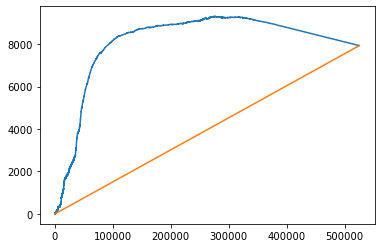

In [18]:
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve
import matplotlib.pyplot as plt

x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_criteo_transf.txt', x1)
np.savetxt('y_criteo_transf.txt', y1)

plt.plot(x1,y1)

plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )  

# Uplift деревья

In [28]:
criterions = ["uplift_gini"]
min_samples_leaf =  [int(x) for x in np.linspace(100, 100000, num = 20)]
stat_param=[40.0]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['uplift_gini'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [100,
                      5357,
                      10615,
                      15873,
                      21131,
                      26389,
                      31647,
                      36905,
                      42163,
                      47421,
                      52678,
                      57936,
                      63194,
                      68452,
                      73710,
                      78968,
                      84226,
                      89484,
                      94742,
                      100000]}


In [29]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(len(indices_train))

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'])
#     sm = OneModel(clf_)


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // 2)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc',auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

3500000
iteration 0  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100} auqc 14267095336.05899
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100} auqc 14624830552.57201
iteration 0, auqc 14445962944.3155, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 100}]
iteration 1  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357} auqc 19169601721.454163
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357} auqc 19987339668.24419
iteration 1, auqc 19578470694.849174, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 5357}]
iteration 2  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 10615}
{'criterion': 'uplift_gini', 'max_features': 0.3, '

{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 26389} auqc 19689753159.366615
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 26389} auqc 20125255893.778515
iteration 26  with params {'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 31647}
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 31647} auqc 19690167146.484108
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 31647} auqc 20009776235.177082
iteration 27  with params {'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 36905}
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 36905} auqc 19606168616.527344
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 36905} auqc 19861903532.65415
iteration 28  with params {'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 42163}
{'criterion': 'uplift_gini', 'max_features': 0.6, 'min_samples_leaf': 42163} auqc 1959

{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 63194} auqc 18504948071.11921
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 63194} auqc 18948083165.446445
iteration 53  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 68452}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 68452} auqc 18424957006.129204
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 68452} auqc 18930308147.52103
iteration 54  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 73710}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 73710} auqc 18218991791.156357
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 73710} auqc 18873954967.788692
iteration 55  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 78968}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 78968} auqc 18293

In [5]:
from uplift.ensemble import RandomForestClassifier

criterions = "uplift_gini"
min_samples_leaf = 15873
max_features = 0.6

uplift_trees = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterions)

uplift_trees = uplift_trees.fit(X_train, Y_train_visit, treatment_train)

In [19]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.511463844797178e-07
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.511463844797178e-07
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785

Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.511463844797178e-07
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Число замеров 100
AUQC: mean:  1717724132.017017 | std:  45127237.73643704
uplift30%: me

In [11]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees.predict_uplift(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
   
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.14452698665146074 | sem:  0.0005928843057716894


Число замеров 100
uplift5%: mean:  0.12205429932812549 | sem:  0.0005089775501418076


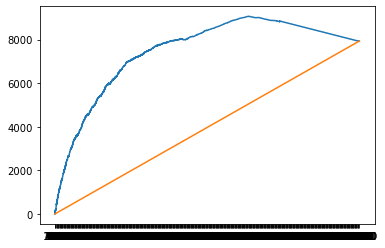

In [20]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees.predict_uplift(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
   
    
    all_res_uplift.append(valid_scores)
    
from uplift.metrics import qini_curve


x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_criteo_uplift_tree.txt', x1)
np.savetxt('y_criteo_uplift_tree.txt', y1)

plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] ) 

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


In [6]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees.predict_uplift(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
   
    
    all_res_uplift.append(valid_scores)
    
from uplift.metrics import qini_curve


x1, y1 = uplift_curve(target_valid, valid_pred, treatment_valid)

x_opt, y_opt = perfect_uplift_curve(target_valid, treatment_valid)

plt.plot(x1,y1)
plt.plot(x_opt, y_opt)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] ) 

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


NameError: name 'plt' is not defined

In [7]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np


random_x = [ x1[0], x1[len(x1)-1] ]
random_y = [ y1[0], y1[len(y1) - 1] ]

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x1, y=y1,
                    mode='lines',
                    name='Model'))
fig.add_trace(go.Scatter(x=random_x, y= random_y,
                    mode='lines',
                    name='Random_model'))
fig.add_trace(go.Scatter(x=x_opt, y=y_opt,
                    mode='lines', name='Optimal model'))



fig.show()

# Uplift деревья со стат тестом

In [30]:
criterions = ["stat_test"]
min_samples_leaf =  [int(x) for x in np.linspace(100, 100000, num = 20)]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['stat_test'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [100,
                      5357,
                      10615,
                      15873,
                      21131,
                      26389,
                      31647,
                      36905,
                      42163,
                      47421,
                      52678,
                      57936,
                      63194,
                      68452,
                      73710,
                      78968,
                      84226,
                      89484,
                      94742,
                      100000]}


In [31]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(len(indices_train))

best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'])
#     sm = OneModel(clf_)


    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // 2)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc',auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

3500000
iteration 0  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 100}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 100} auqc 14234449077.57386
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 100} auqc 14205086620.57684
iteration 0, auqc 14219767849.07535, params [{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 100}]
iteration 1  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 5357}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 5357} auqc 18049300594.797386
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 5357} auqc 19155233607.09071
iteration 1, auqc 18602267100.944046, params [{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 5357}]
iteration 2  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 10615}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 

{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 26389} auqc 18767858971.149292
{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 26389} auqc 18987905208.950413
iteration 26  with params {'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 31647}
{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 31647} auqc 19273310257.74536
{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 31647} auqc 19124434264.280117
iteration 27  with params {'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 36905}
{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 36905} auqc 18468776418.952423
{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 36905} auqc 19117570817.813244
iteration 28  with params {'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 42163}
{'criterion': 'stat_test', 'max_features': 0.6, 'min_samples_leaf': 42163} auqc 18748030613.565483
{'cri

{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 68452} auqc 16384252850.392143
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 68452} auqc 17606101467.8112
iteration 54  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 73710}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 73710} auqc 16601606325.42743
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 73710} auqc 17568803832.202328
iteration 55  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 78968}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 78968} auqc 16342275295.251793
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 78968} auqc 17784523405.459248
iteration 56  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 84226}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 84226} auqc 17816951244.600204
{'crite

In [22]:
from uplift.ensemble import RandomForestClassifier

criterions = "stat_test"
min_samples_leaf = 31647
max_features = 0.3

uplift_trees_stat = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterions)

uplift_trees_stat = uplift_trees.fit(X_train, Y_train_visit, treatment_train)

In [21]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees_stat.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.511463844797178e-07
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.51146384479717

Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Число замеров 100
AUQC: mean:  1719161081.4761353 | std:  44538008.53383095
uplift30%

In [13]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees_stat.predict_uplift(X_valid)
   
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.13132651876725843 | sem:  0.0006126088735616975


Число замеров 100
uplift5%: mean:  0.12581423910043285 | sem:  0.000528082929618566


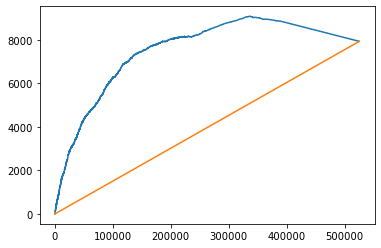

In [23]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = uplift_trees_stat.predict_uplift(X_valid)
   
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
    

    
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve

x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_criteo_stat_test.txt', x1)
np.savetxt('y_criteo_stat_test.txt', y1)

plt.plot(x1,y1)

plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )   

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


# Две независимые модели

In [26]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 8, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)




{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 8],
 'subsample': [0.4, 0.7, 1.0]}


In [32]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc_two = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_two = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(len(indices_train))


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params_t in enumerate(grid_list):
    print("iteration", j," with params", params_t)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )
    
    
    clf_c = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )




    auqc_res= []

    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // 2)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values

        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):

            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)

            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')

            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break

            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)


            print(params_t, 'auqc',auqc)

            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1

        auqc_res.append(best)   

    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc_two[j] = mid
        best_param_auqc_two[j] = [params_t]
        print("iteration {}, auqc {}, params {}".format(j, mid, [params_t]))
        best_auqc = mid

    
    


3500000
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10421729808.279099
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 14724038563.371857
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 15459753367.978096
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 14504824692.746048
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 14493864214.240257
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 15295339484.250687
[ 182 ]
earlystopping finish, best iteration 92
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5574423691.909531
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 15737651100.798267
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 15881177353.957996

start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 14397538819.845669
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 16186468907.48962
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 16087872962.415585
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 15624247887.945316
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 15521795383.442806
[ 152 ]
earlystopping finish, best iteration 62
iteration 6  with params {'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14550761563.430077
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 15160808482.164421
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14818308485.419022
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 14482742983.038063
[ 122 ]


{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16422861004.810219
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16044495272.734825
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15487189341.909363
[ 362 ]
earlystopping finish, best iteration 272
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 3260964413.472023
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 4947000349.873932
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 10763658966.864399
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 13548976536.148968
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15884426160.791859
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15487405863.582706
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15275237878.370045
[ 212 ]
{'colsample_bytre

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.7} auqc 14921480774.838284
[ 182 ]
earlystopping finish, best iteration 92
iteration 17  with params {'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 12784996461.932793
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 13801458066.715927
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14286329904.301674
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14547205341.007935
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 15143087601.852684
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 15242367487.649803
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14981498191.459915
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14921173350.87606
[ 242 ]
{'colsample_bytree': 0.

start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 10216983135.942623
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11916503270.16011
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11915321643.780418
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11935410837.503746
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 12013921490.204796
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 12066451896.169426
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11987535843.926163
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 12050244415.447708
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 12171305916.54554
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 12241160214.379112
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7

{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 15765324294.56546
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 16198025762.610039
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 15881189449.2529
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 15779113134.71949
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 15761123062.58799
[ 362 ]
earlystopping finish, best iteration 272
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 1462927148.2592964
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 4038787196.5286064
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 5878880319.520287
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 13143845673.037762
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 13856335887.224964
[ 152 ]
{'colsample_bytree': 

{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14405455307.567238
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14492103523.33702
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14319028623.369179
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14366709574.787071
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14427515797.659256
[ 242 ]
earlystopping finish, best iteration 152
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 9702983226.009747
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14396890201.03407
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 15021325595.3261
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 14894526220.255505
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 1.0} auqc 15111075597.658794
[ 152 ]
{'colsample_bytree':

{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11185918396.186527
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11123622563.207752
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11224781616.088264
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11244884428.510864
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11251410086.492195
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11332926076.440361
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11354980447.839203
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11451814170.213799
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11481035745.157402
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11529083543.851776
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 8, 'subsample': 0.7} auqc 11443103373.5630

In [34]:
print(accuracy_auqc_two)
print(best_param_auqc_two)
print(best_auqc)

{0: 16312006402.741404}
{0: [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}]}
16312006402.741404


In [14]:
from lightgbm import LGBMClassifier
from uplift.models import TwoModels

max_depth = 2
subsample = 0.4
colsample_bytree = 0.4
lr = 0.01
RANDOM_STATE = 12
n_est = 242

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
    
    
clf_c = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_independent')

two = two.fit(X_train, Y_train_visit, treatment_train)

In [6]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.0001151895943

Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Число замеров 100
AUQC: mean:  1393277303.674515 | std:  48817476.28910998
uplift30%: 

In [15]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = two.predict(X_valid)
   
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.12479631745863225 | sem:  0.0005778060132064032


# Две зависимые T C

In [35]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 8, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)




{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 8],
 'subsample': [0.4, 0.7, 1.0]}


In [36]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc_two = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_two = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(len(indices_train))


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params_t in enumerate(grid_list):
    print("iteration", j," with params", params_t)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )
    
    
    clf_c = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )




    auqc_res= []

    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // 2)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values

        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):

            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)

            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')

            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break

            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)


            print(params_t, 'auqc',auqc)

            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1

        auqc_res.append(best)   

    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc_two[j] = mid
        best_param_auqc_two[j] = [params_t]
        print("iteration {}, auqc {}, params {}".format(j, mid, [params_t]))
        best_auqc = mid

    
    


3500000
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc -361210377.06757355
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 12152172508.060158
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 8780347608.324303
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 9615741868.628796
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 11528436715.935486
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc -929369218.4930153
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10967306444.628193
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 8856703050.47171
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 10467614663.6534
[ 12

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 13052328854.576992
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 9433886092.91518
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 9971077488.655304
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 9391339636.782284
[ 152 ]
earlystopping finish, best iteration 62
iteration 6  with params {'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc -2136598756.5701256
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 11959908019.996796
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 8633552551.260353
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 8974163698.576244
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.4} auqc 8579217443.369072
[ 152 ]
earlystopping finish, best iter

{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 14487570680.33059
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 14305183145.988953
[ 362 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 14840910053.357704
[ 392 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 14469344584.224213
[ 422 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15382929952.40136
[ 452 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16102125996.82492
[ 482 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15872430601.40419
[ 512 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16158235729.893936
[ 542 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15943201915.123909
[ 572 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 16063687237.444565
[ 602 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4} auqc 15838274595.030174


{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 2989814083.8999214
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 10367006322.060272
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 12753796848.508457
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 13771913740.344707
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 13548746935.519505
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 13092819437.733303
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 14506650411.139912
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15209323896.762287
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15342360993.853634
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 14880407015.741581
[ 362 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15129883186.5569

{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14229992686.579887
[ 422 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14329777353.043251
[ 452 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 14019038063.770859
[ 482 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 13917066203.877098
[ 512 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 13969932548.594841
[ 542 ]
earlystopping finish, best iteration 452
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc -315728563.9290581
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 12686205889.131931
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 13360819597.319477
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 13305154915.355358
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 13705593390.232311
[ 152 ]
{'colsample_byt

start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 4262237539.05101
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 11325516002.58451
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 11366492489.550255
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 11121702119.884777
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 11631967221.743698
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 12159965285.05503
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 12095546750.779037
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 12506847364.578697
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 12674231223.46553
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 12567725188.048233
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} a

{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 10498272352.580856
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 10671199368.014439
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11153889426.119114
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11452060967.453922
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11221710051.340794
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11805918559.632633
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 12019446358.212696
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11612280950.246792
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11879608686.168316
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 8, 'subsample': 0.7} auqc 11854614918.446781
[ 362 ]
earlystopping finish, best iteration 272
iteration 23  with params {'colsample_by

{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 14725565887.465412
[ 302 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.4} auqc 14653673640.592457
[ 332 ]
earlystopping finish, best iteration 242
iteration 28  with params {'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 6250263383.377514
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13095563705.263542
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 12529421348.040451
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 12718290474.20713
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13792629583.422897
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 13832382860.622917
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.7} auqc 14358197808.976845
[ 212 ]
{'colsample_bytree': 1.

{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12662815853.870766
[ 122 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12900096799.615227
[ 152 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12996329037.806503
[ 182 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12757684083.0122
[ 212 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12906869624.710274
[ 242 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 12622525979.659729
[ 272 ]
earlystopping finish, best iteration 182
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 9009873504.471344
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 11793130655.472927
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 13344443127.620129
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 13220206651.461346
[ 122 ]
{'colsample_bytree

In [37]:
print(accuracy_auqc_two)
print(best_param_auqc_two)
print(best_auqc)

{0: 13609039764.308084, 3: 13795017308.072863, 12: 15750298361.873785}
{0: [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 3: [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}], 12: [{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.4}]}
15750298361.873785


In [17]:
from lightgbm import LGBMClassifier
from uplift.models import TwoModels

max_depth = 2
subsample = 0.4
colsample_bytree = 0.7
lr = 0.01
RANDOM_STATE = 12
n_est = 512

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
    
    
clf_c = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
two_treat = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_treatment')

two_treat = two_treat.fit(X_train, Y_train_visit, treatment_train)

In [8]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = two_treat.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift r

Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Число замеров 100
AUQC: mean:  1097885395.5064774 | std:  52056828.87831965
uplift30%: mean:  0.05049231568066694 | std:  0.0015599440363812669
Kendall_rank_correlation: mean:  0.5568890863946379 | std:  0.0595514300340478
AUUC: mean:  0.046795946710994185 | std:  0.00218730918650

In [18]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = two_treat.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)

    
    all_res_uplift.append(valid_scores)
   
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.07469649573533267 | std:  0.0008354343205323439


# Две зависимые C T

In [5]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 8, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)




{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 8],
 'subsample': [0.4, 0.7, 1.0]}


In [6]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc_two = {}
accuracy = {}
num_folds = 2
# eval_set = [(np.column_stack((eval_x,eval_treat)), eval_y)]
best_param = {}
best_param_auqc_two = {}
indices_all_folds = np.array_split(indices_train, num_folds)
#cross validation
print(len(indices_train))


lr = 0.01
RANDOM_STATE = 12

best_auqc = 0.0
for j, params_t in enumerate(grid_list):
    print("iteration", j," with params", params_t)
    
    clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )
    
    
    clf_c = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**params_t['max_depth'] -1,
            max_depth=params_t['max_depth'],
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=params_t['subsample'],
            colsample_bytree = params_t['colsample_bytree']
    )




    auqc_res= []

    for i in range(num_folds):

        x_val = df_features.loc[indices_all_folds[i]].values
        y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
        treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(len(indices_train) // 2)

        x_train = df_features.loc[united].values
        y_train = df_dataset.loc[united, 'visit'].values
        treatment_train = df_dataset.loc[united, 'treatment'].values

        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):

            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_t.set_params(**seting)
            clf_c.set_params(**seting)

            two = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')

            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break

            two.fit(x_train,y_train,treatment_train)
            pred = two.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)


            print(params_t, 'auqc',auqc)

            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1

        auqc_res.append(best)   

    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc_two[j] = mid
        best_param_auqc_two[j] = [params_t]
        print("iteration {}, auqc {}, params {}".format(j, mid, [params_t]))
        best_auqc = mid

    
    


3500000
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc -2208654033.062134
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 11858616719.785118
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 16821327605.618553
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 17278369783.918045
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 17008526430.381187
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 16754198330.730865
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 16299907197.63224
[ 212 ]
earlystopping finish, best iteration 122
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc -1100653122.3935356
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 11998568629.072

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 17797929952.898426
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 17816413661.62042
[ 272 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 17830253642.1702
[ 302 ]
earlystopping finish, best iteration 212
iteration 5  with params {'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 12916502871.183975
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 15314248198.743896
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 16913664544.392838
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 17296895117.23342
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 17139203841.508575
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 1.0} auqc 17099362386.409248
[ 182 ]
{'colsample_bytree': 0.4, 

start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 14686174313.794022
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 14765990683.848915
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 16719889271.702744
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 16798750583.63279
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 16843254185.00933
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 16432408930.617638
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 16136446486.84134
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 15805827909.26052
[ 242 ]
earlystopping finish, best iteration 152
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 14640338631.876965
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 0.7} auqc 15246463544.005398
[

{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15524283660.60661
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15088728283.392567
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15685474706.986134
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15528412364.971508
[ 242 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 15168692886.53413
[ 272 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 9125696270.785702
[ 302 ]
earlystopping finish, best iteration 212
iteration 15  with params {'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 11808141713.907547
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16621488788.924408
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16474323026.060196
[ 92 ]
{'colsample_bytree': 0.7

KeyboardInterrupt: 

In [7]:
print(accuracy_auqc_two)
print(best_param_auqc_two)
print(best_auqc)

{0: 17412745093.088165, 3: 17650591433.785225}
{0: [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}], 3: [{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4}]}
17650591433.785225


In [19]:
from lightgbm import LGBMClassifier
from uplift.models import TwoModels

max_depth = 4
subsample = 0.4
colsample_bytree = 0.4
lr = 0.01
RANDOM_STATE = 12
n_est = 182

clf_t = LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='binary',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )
    
    
clf_c = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=lr,
        random_state=RANDOM_STATE,
        objective='binary',
        reg_alpha=0.0,
        reg_lambda=0.0,
        silent=True,
        subsample=subsample,
        colsample_bytree = colsample_bytree
)
two_control = TwoModels(estimator_trmnt = clf_t, estimator_ctrl = clf_c, method='two_dependent_control')

two_control = two_control.fit(X_train, Y_train_visit, treatment_train)

In [11]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = two_control.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.7191465199607916 with p_value =  0.004057136032371292
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift r

Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.3595732599803958 with p_value =  0.15076277502664528
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.007058332048528094
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
Число замеров 100
AUQC: mean:  1208700710.6414084 | std:  192941542.0410209
uplift30%: mean:  0.05621661328812056 | std:  0.0016447434773355666
Kendall_rank_correlation: mean:  0.6175670740163297 | std:  0.09806202943118002
AUUC: mean:  0.04943972528592684 | std:  0.00895645521737905

In [20]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = two_control.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)

    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ", stats.sem(all_res_uplift))


Число замеров 100
uplift5%: mean:  0.13137795312359996 | sem:  0.0006382154186139572


# Трансформация классов( регрессия )

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler 

N_ROWS = 5000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = N_ROWS)

df_dataset = reduce_mem_usage(df_dataset)


df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
},index = df_dataset.index)
#fit on 
indices_all =  [i for i in range(df_dataset.shape[0])]

p = 0.845832

df_dataset['Z_trans'] = df_dataset['visit']* ( (df_dataset['treatment'] - p) / ( p*(1-p) ) )

indices_train, indices_test = train_test_split(indices_all,test_size = 0.3)
# indices_test, indices_eval = train_test_split(indices_test, test_size = 0.5)

X_train = df_features.loc[indices_train].values
treatment_train = df_dataset.loc[indices_train,'treatment'].values
Y_train_visit = df_dataset.loc[indices_train,'visit'].values
Z_train = df_dataset.loc[indices_train,'Z_trans'].values

X_test = df_features.loc[indices_test].values
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values
Z_test = df_dataset.loc[indices_test,'Z_trans'].values

# X_eval = df_features.loc[indices_eval].values
# Y_eval_visit =  df_dataset.loc[indices_eval,'visit'].values
# treatment_eval = df_dataset.loc[indices_eval,'treatment'].values


scaler = StandardScaler(with_std = True, with_mean = True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# X_eval = scaler.fit_transform(X_eval)


Mem. usage decreased to 133.51 Mb (78.1% reduction)


In [28]:
from lightgbm import LGBMClassifier
from uplift.models import OneModel

max_depth = 4
subsample = 1.0
colsample_bytree = 0.4
lr = 0.01
RANDOM_STATE = 12
n_est = 92

clf_reg = LGBMRegressor(
            boosting_type='gbdt',
            n_estimators = n_est,
            num_leaves=2**max_depth -1,
            max_depth=max_depth,
            learning_rate=lr,
            random_state=RANDOM_STATE,
            objective='regression',
            reg_alpha=0.0,
            reg_lambda=0.0,
            silent=True,
            subsample=subsample,
            colsample_bytree = colsample_bytree
    )


clf_reg = clf_reg.fit(X_train, Z_train)

In [29]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
uplift_five = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values
    
    X_valid = scaler.fit_transform(X_valid)

    valid_pred = clf_reg.predict(X_valid)
  
   
    
    uplift_at_five = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    
    
 
    uplift_five.append(uplift_at_five)
    

print('uplift5%',np.mean(uplift_five),"| sem: ", stats.sem(uplift_five) )

uplift5% 0.14082906156782718 | sem:  0.0007118827926117467
